In [1]:
# Libraries
import os
import json
import re
from langdetect import detect # Library for language detection
from spellchecker import SpellChecker
import string
import spacy
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
#os.chdir('C:\\GitHub Repositories\\NLP-Detection-of-Negation-and-Uncertainty-Project-24\\Data')

In [3]:
# Loading the json file
loading = open("negacio_train_v2024.json")
training_data = json.load(loading)
print(len(training_data))

254


In [4]:
!python -m spacy download es_core_news_sm
!python -m spacy download ca_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 459.4 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 753.7 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')


In [5]:
# 1 Remove pacient information and redacted entries
def remove_pacient_info(text):
    # Remove lines starting with "nº historia clinica:" and ending with "motiu d'ingres"
    text = re.sub(r'nº historia clinica:.*?motiu d\'ingres', '', text, flags=re.DOTALL)
    # Remove lines starting with "nhc" and ending with "lopd"
    text = re.sub(r'nhc.*?lopd', '', text, flags=re.DOTALL)
    # Remove all asterisks '*'
    text = text.replace('*', '')
    return text


# 2 Remove Punctuation (Able to be turned ON/OFF)
def remove_punctuation(text):
    # Define a translation table to map punctuation to None
    translator = str.maketrans('', '', string.punctuation)
    # Remove punctuation using the translation table
    text = text.translate(translator)
    return text


# 3 Spell cheking with language detection (Able to be turned ON/OFF)
# Load language models for Spanish and Catalan
nlp_es = spacy.load("es_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")

def lemmatize_text(text):
    # Detect the language of the text
    language = detect(text)

    # Tokenize the text using the appropriate language model
    if language == 'ca':
        doc = nlp_ca(text)
    else:
        doc = nlp_es(text)

    # Lemmatize tokens
    lemmatized_tokens = []
    for token in doc:
        # Check if the token is a punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # Lemmatize the token
            lemmatized_token = token.lemma_ if token.lemma_ != '-PRON-' else token.text
            lemmatized_tokens.append(lemmatized_token)
        else:
            lemmatized_tokens.append(token.text)

    # Join the tokens back into text
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


# 4 Tokenization with coordinates of the original text for (evaluation)
def tokenize_with_coordinates(text):
    # Tokenize the text while preserving the coordinates
    tokens_with_coordinates = []
    token_start = 0
    for token in re.finditer(r'\S+', text):
        token_text = token.group(0)
        token_end = token_start + len(token_text)
        tokens_with_coordinates.append((token_text, token_start, token_end))
        # Update token start position for the next token
        token_start = token_end
    return tokens_with_coordinates


# Main function to process the text
def pre_process_text(text, remove_punctuation_call=True, spell_check_call=True):

    # 1 Remove pacient information and redacted entries
    preprocessed_text = remove_pacient_info(text)

    # 2 Remove punctuation if specified
    if remove_punctuation_call:
        preprocessed_text = remove_punctuation(preprocessed_text)

    # 3 Spell check and lemmatize if specified
    if spell_check_call:
        preprocessed_text = lemmatize_text(preprocessed_text)

    # 4 Tokenize the text with coordinates
    tokens_with_coordinates = tokenize_with_coordinates(preprocessed_text)

    return tokens_with_coordinates

## <span style="color:red; font-size:larger;">**DATA ANNOTATION**</span>


In [6]:

#EXTRACTED FROM THE TRAINING SET
neg_pre = ['impide', 'exfumador', 'negativo', 'desaparecen', 'asintomatica', 'afebril', 'se desestimo', 'negativos', 'ninguno', 'asintomatico', 'desorientado', 'inestabilidad', 'atipicos', 'ausencia de', 'ceden', 'negativa', 'negativas', 'excepto', 'desorientacion', 'inespecificos', 'se suspende','inespecifico', 'ex', 'arritmicos', 'cede', 'se retira', 'ex fumador', 'niegan', 'negatiu', 'negaitvo', 'indetectable',' negativo', 'suspendido']
neg_pos = ['retirar','ni' 'desaparicion de', 'descarta', 'ausencia', 'descartada', 'niega', 'nega', 'rechaza', 'desaparicion del', 'imposibilidad', 'retiro', 'irregulares', 'negatividad', 'tampoco', 'sin', 'imposibilidad de', 'en ninguna', 'incapacidad para', ' no', 'neg', ' afebril', 'sense', 'falta de', 'negatividad de', 'negatividad del', 'no']
#EXTRACTED FROM THE GITHUB
neg_pre_filtered= ['gobierna al paciente', 'ninguna otra evidencia', 'la van descartar per', 'no aparece', 'descartaron al paciente por', 'adecuado para descartarla', 'excluir', 'excloure', 'descartar al pacient per', 'sin ninguna evidencia de', 'descartarlo por', 'no tenía', 'lo descartó', 'sin signo de', 'sense indicació de', 'pot descartar', 'excluye', 'ho descarta', 'ninguna evidencia radiográfica de', 'descartarlo', 'negando', 'sense troballes de', 'adequat per a descartar-lo', 'cap senyal de', 'no em queixo de', 'ninguna señal de', 'nunca tuve', 'ho va descartar', 'descartar', 'lo descartaron por', 'la va descartar contra', 'pot descartar-ho', 'lo descartaron en contra', 'libre de', 'pot descartar al pacient', 'no tinc', 'absència de', 'sin quejas de', 'van descartar contra', 'la va descartar', 'no tenia', 'descartado contra', 'ho va descartar contra', 'no me quejo de', 'puede descartar', 'no significativo', 'resuelto', 'puede descartar al paciente', 'no sospitós', 'gens especial per a', 'pot descartar-ho per', 'exclou', 'r / o', 'resolt', 'van descartar per a', 'descartó', 'va descartar', 'puede descartarla contra', 'sin evidencia', 'descartar per a', 'no apareix', 'pot descartar-la per', 'la descartó', 'va descartar al pacient', 'descartar-ho', 'cap altra evidència', 'no saber de', 'ninguna nueva evidencia', 'sin indicación de', 'mai desenvolupat', 'sense queixes de', "l'exclou", 'lo descarta', 'cap suggeriment de', 'cap evidència radiogràfica de', 'sense cap evidència de', 'puede descartarlo', 'pacient no era', 'no apreciar', 'con ningún', 'cap causa de', 'adecuado para descartarlo', 'no associat amb', 'descartarla', 'nunca desarrollado', 'adecuado para descartarla por', 'no poden veure', 'ro', 'ninguna evidencia para sugerir', 'sin hallazgos de', 'no pueden ver', 'pot descartar-la', 'la excluye', 'governa al pacient', 'amb cap', 'descartar al paciente por', 'expulsó al paciente por', 'no anormal', 'no sospechoso', 'pot descartar-la contra', 'nada nuevo', 'paciente no era', 'descartaron para', 'no poder', 'evaluar por', 'suficiente para descartarlo por', 'no exhibir', 'més aviat que', 'fer una prova per', 'puede descartarla por', 'ninguna causa de', 'lliure de', 'mai vaig tenir', 'no tengo', 'descartaron contra', 'puede descartarla', 'adecuado para descartarlo por', 'descartat contra', 'descartar-la', 'adequat per a descartar-la', 'no significatiu', 'negatiu per a', 'sense evidència', 'ho van descartar per', 'descartar al pacient', 'cap nova evidència', 'descartarla por', 'nada especial para', 'ninguna sugerencia de', 'sense signe de', 'no sentir', 'descartar al paciente', 'descartar-ho per', 'puede descartarlo en contra', 'puede descartarlo por', 'más bien que', 'res nou', 'descartó al paciente', 'negant', 'avaluar per', 'no demostrar', 'descartar para', 'no revela', 'no revelar', 'descartó al paciente contra', 'puede descartar contra', 'descartar-la per', 'suficiente para descartar', 'negativo para', 'la descartó contra', 'revisado para', 'suficient per a descartar', 'revisat per a', 'hacer una prueba por', 'pot descartar-ho en contra', 'pot descartar contra', 'la descartaron por', 'descartaron al paciente contra', 'no asociado con', 'suficiente para descartarla por', 'lo descartó contra']
neg_pos_filtered= ['libre', 'podría ser descartado', 'fue descartado', 'rechazado', 'ha de ser descartat', 'lliure', 'rebutjat', 'puede ser descartado', 'ser descartat', 'adecuado para descartar', 'están descartadas', 'podria ser descartat', 'improbable', 'podría ser descartado por', 'debe ser descartado por', 'suficient per a descartar-ho', 'serà descartat per', 'podria descartar-se', 'suficient per a descartar-la', 'va ser descartat', 'han estat descartades', 'ser descartado por', 'declina', 'adequat per a descartar', 'siendo descartado', 'suficiente para descartarla', 'no ver', 'sent descartat', 'està descartat', 'se puede descartar por', 'pot ser descartat', 'ha estat descartat', 'puede ser descartado para', 'ha de descartar-se', 'suficiente para descartarlo', 'es descarta', 'ha sido descartado', 'será descartado', 'ser descartado', 'no veure', 'ser descartat per', 'debe ser descartado', 'serà descartat', 'debe descartarse para', 'debe ser descartado para', 'es pot descartar per', 'negado', 'se descarta', 'lo descartaron', 'no ser', 'se puede descartar', 'está descartado', 'negat', 'podría descartarse', 'es pot descartar', 'ho van descartar', 'podria ser descartat per', 'han sido descartadas', 'será descartado por', 'estan descartades', 'debe descartarse']
neg_pre.extend(neg_pre_filtered)
neg_pos.extend(neg_pos_filtered)

#NOSE COM EMFOCAR: SIN, NO, DESCARTAR
unc_pre = [ 'al parecer' , 'vs', 'dudosamente', 'indeterminado', 'sospecha', 'pudieran', 'aparentes', 'dubtos','permite descartar', 'parece', 'atribuida', 'clara', 'no clara', 'desconocido']
unc_pos = ['compatible amb', 'desconoce', 'indiquen', 'sin aparente', 'sugieren', 'ssospechosas de', 'probablemente', 'posible', 'sugestivo de', 'falsa', 'sospechan de', 'posibilidad de', 'sugiriendo', 'orienta', 'sospechosos de', 'sugestivos de', 'se orienta', 'plantea', 'podria', 'puede', 'podrian', 'probables', 'no', 'sugiere', 'parecen', 'sin', 'sospechosa de', 'sugestivas de', 'orientan como', 'dudosa', 'interpreta', 'compatible con', 'valorar', 'dudosos', 'probable', 'poco porque', 'sugieran', 'sin clara', 'no permite descartar', 'se desconoce', 'impresiona de', 'sugestiva de', 'orienta como', 'orientan', 'sin poder descartar', 'no parece', 'sospitosa de', 'sugestivos con', 'impresiona', 'aparentemente', 'sospecha de', 'no es posible descartar', 'compatibles con', 'compatible', 'aparente', 'sugestiva como', 'posiblemente', 'posibles', 'sugiera de', 'descartar', 'dudoso', 'se orientan', 'sospechosas de', 'sin aparentes', 'sin claras']
#DEMA HO AFEGEIXO
unc_pre_filtered = ['como una causa secundaria para', 'como el origen secundario de', 'secundario a', 'como la causa de', 'como la causa secundaria de', 'como una razón de', 'como una causa secundaria de', 'como una etiología secundaria para', 'excepto', 'aunque', 'como la fuente secundaria para', 'como una etilogía para', 'como la fuente de', 'como el origen secundario para', 'com la font secundària de', 'como una razón secundaria para', 'com una raó secundària per a', 'com la font secundària per a', 'com una etiologia de', 'como una etiología secundaria de', 'secundari a', 'encara que', 'como una razón secundaria de', 'como la razón secundaria de', 'como la fuente secundaria de', 'com la causa secundària de', 'a pesar que', 'como una razón para', 'como la etilogía de', "com l'etiologia de", 'como la razón secundaria para', 'como un origen secundario para', 'com una font secundària per a', 'como una etilogía de', 'como fuente de', "com l'etiologia secundària per a", "com l'origen secundari per a", "com l'origen secundari de", 'però', 'com a causa de', 'com una etiologia secundària per a', 'como la razón de', 'com un origen secundari per a', 'com una raó secundària de', 'no obstant això', 'com una font secundària de', 'com una raó per a', 'pero', 'com la raó secundària de', 'como la etilogía secundaria para', 'a pesar de que', 'sin embargo', "com l'etiologia secundària de", 'com la causa de', 'com una causa secundària per a', 'com la raó de', 'a part de', 'como una fuente secundaria de', 'com una causa secundària de', 'aparte de', 'com a font de', 'como una fuente secundaria para', "com l'origen de", 'com una etiologia per a', 'com la raó secundària per a', 'como el origen de', 'com un origen secundari de', 'com una raó de', 'como un origen secundario de', 'excepte', 'como causa de', 'encara', 'todavía', 'com una etiologia secundària de', 'como la etilogía secundaria de']
unc_post_filtered =['origens de', 'raons de', 'altres possibilitats de', 'font per a', 'desencadenar evento para', 'origen para', 'raons per a', 'fuente para', 'causes de', 'fuentes de', 'causa de', 'etilogia de', 'etilogía para', 'origen per a', 'motivo de', 'fuentes para', 'otras posibilidades de', 'razones de', 'causas de', 'font de', 'razones para', 'etilogía de', 'fonts per a', 'fonts de', 'raó per a', 'razón de', 'orígenes para', 'razón para', 'motiu de', 'desencadenar esdeveniment per a', 'fuente de', 'orígenes de', 'origen de', 'raó de', 'etilogia per a', 'origens per a']
unc_pre.extend(unc_pre_filtered)
unc_pos.extend(unc_post_filtered)


In [7]:
'''
def annotate_text(text):
    # Define negation and uncertainty cues
    # Tokenize the text
    tokens = text.split()

    # Initialize labels list
    labels = []

    # Iterate through tokens and annotate
    for token in tokens:
        # Check if token is a negation cue
        if token.lower() in neg_pre:
            labels.append("NEG-PRE")
        elif token.lower() in neg_pos:
            labels.append("NEG-POS")

        # Check if token is an uncertainty cue
        elif token.lower() in unc_pre:
            labels.append("UNC-PRE")
        elif token.lower() in unc_pos:
            labels.append("UNC-POS")

        else:
            labels.append("O")  # Not negation or uncertainty

    return labels
    '''

'\ndef annotate_text(text):\n    # Define negation and uncertainty cues\n    # Tokenize the text\n    tokens = text.split()\n\n    # Initialize labels list\n    labels = []\n\n    # Iterate through tokens and annotate\n    for token in tokens:\n        # Check if token is a negation cue\n        if token.lower() in neg_pre:\n            labels.append("NEG-PRE")\n        elif token.lower() in neg_pos:\n            labels.append("NEG-POS")\n\n        # Check if token is an uncertainty cue\n        elif token.lower() in unc_pre:\n            labels.append("UNC-PRE")\n        elif token.lower() in unc_pos:\n            labels.append("UNC-POS")\n\n        else:\n            labels.append("O")  # Not negation or uncertainty\n\n    return labels\n    '

In [8]:
def annotate_text(text):
    # Define negation and uncertainty cues
    # Tokenize the text
    # Initialize labels list
    labels = []

    # Iterate through tokens and annotate
    for token in text:
        # Check if token is a negation cue
        if token[0].lower() in neg_pre:
            labels.append("NEG")
        elif token[0].lower() in neg_pos:
            labels.append("NEG")

        # Check if token is an uncertainty cue
        elif token[0].lower() in unc_pre:
            labels.append("UNC")
        elif token[0].lower() in unc_pos:
            labels.append("UNC")

        else:
            labels.append("O")  # Not negation or uncertainty

    return labels

## <span style="color:red; font-size:larger;">**FEATURE EXTRACTION FUNCTIONS**</span>


2. INITIATES WITH CAPITALIZATION

In [9]:
def init_cap(text):
    capitalized_words_list = []
    for word in text:
        capitalized_word_dict = {}
        if word.istitle():
            capitalized_word_dict[word] = '1'
        else:
            capitalized_word_dict[word] = '0'
        capitalized_words_list.append(capitalized_word_dict)
    return capitalized_words_list


CONTAINS CAPITALIZATION

In [10]:
def contains_cap(text):
    contain_cap_words_list = []
    for word in text:
        contain_cap_word_dict = {}
        if any(char.isupper() for char in word):
            contain_cap_word_dict[word] = '1'
        else:
            contain_cap_word_dict[word] = '0'
        contain_cap_words_list.append(contain_cap_word_dict)
    return contain_cap_words_list


3. IS A NUMBER

In [11]:
def is_a_number(text):
    is_num_list = []
    for word in text:
        is_num_dict = {}
        try:
            float(word)
            is_num_dict[word] = '1'
        except ValueError:
            is_num_dict[word] = '0'
        is_num_list.append(is_num_dict)
    return is_num_list


4. CONTAINS A NUMBER

In [12]:
def contains_number(text):
    contains_num_list = []
    for word in text:
        contains_num_dict = {}
        if any(char.isdigit() for char in word):
            contains_num_dict[word] = '1'
        else:
            contains_num_dict[word] = '0'
        contains_num_list.append(contains_num_dict)
    return contains_num_list


HAS DASH (-)

In [13]:
def contains_dash(text):
    contain_dash_words_list = []
    for word in text:
        contain_dash_word_dict = {}
        if '-' in word:
            contain_dash_word_dict[word] = '1'
        else:
            contain_dash_word_dict[word] = '0'
        contain_dash_words_list.append(contain_dash_word_dict)
    return contain_dash_words_list


In [14]:
def contains_underscore(text):
    contain_underscore_words_list = []  # Initialize an empty list to store dictionaries
    for word in text:
        word_dict = {}  # Create a dictionary for the current word
        if '_' in word:
            word_dict[word] = '1'
        else:
            word_dict[word] = '0'
        contain_underscore_words_list.append(word_dict)  # Append the dictionary to the list
    return contain_underscore_words_list


In [15]:
import string

def contains_punctuation(text):
    contain_punct_words_list = []
    for word in text:
        if any(char in string.punctuation for char in word):
            contain_punct_words_list.append(1)
        else:
            contain_punct_words_list.append(0)
    return contain_punct_words_list


In [16]:
def pos_tag_words(text):
    chunk_size = 30000
    tagged_words_list = []  # Initialize an empty list to store tuples of (word, pos_tag)
    for i in range(0, len(text), chunk_size):
        chunk = ' '.join(text[i:i+chunk_size])
        # Tokenize the chunk
        doc = nlp_es(chunk)
        # Extract POS tags and append to the list
        tagged_words_list.extend((token.text, token.pos_) for token in doc)
    return tagged_words_list


In [17]:
def beforepos(pos_tags, text):
    features = []
    # Iterate over each word and its corresponding POS tag
    for i, (word, pos_tag) in enumerate(zip(text, pos_tags)):
        # Extract POS tags of the previous 6 words (or less if near the beginning)
        prev_pos_tags = pos_tags[max(0, i - 6):i]
        # Pad with empty strings if less than 6 previous words
        prev_pos_tags = [''] * (6 - len(prev_pos_tags)) + prev_pos_tags
        # Add the features for the current word
        features.append({word:prev_pos_tags})
    return features


In [18]:
def afterpos(pos_tags, text):
    word_features_list = []

    for i, (word, pos_tag) in enumerate(zip(text, pos_tags)):
        word_features = {}  # Initialize a new dictionary for each word
        # If it's not the last word
        if i < len(pos_tags) - 1:
            # Extract POS tag of the following word
            next_pos_tag = pos_tags[i + 1]
            # Store the feature for the current word
            word_features[word] = next_pos_tag
        else:
            # If it's the last word, add a placeholder feature
            word_features[word] = 'END'  # Placeholder for end of text
        word_features_list.append(word_features)  # Append the dictionary to the list

    return word_features_list


In [19]:
def beforegram(text):
    word_features_list = []

    for i, word in enumerate(text):
        prev_pos_tags = text[max(0, i - 7):i]  # Get preceding POS tags, up to 7 words before the current word
        features = []
        if len(prev_pos_tags) == 0:
            features.append(['START'])  # Add 'START' as a placeholder feature when there are no previous n-grams
        else:
            for j in range(len(prev_pos_tags) - 1):
                features.append(prev_pos_tags[j:j+2])  # Append bigram of preceding POS tags
        word_features_list.append({word: features})  # Append word features to the list as a dictionary

    return word_features_list


In [20]:
def aftergram(text):
    word_features_list = []

    for i, word in enumerate(text):
        features = []
        if i < len(text) - 1:
            features.append(text[i:i+2])  # Append bigram of the current word and the following word
        else:
            features.append(['', 'END'])  # If it's the last word, append a placeholder bigram
        word_features_list.append({word: features})  # Store features for the current word as a dictionary

    return word_features_list


In [21]:
vocabulary_words = []

for entry in training_data:
    text = entry["data"]["text"]  # Extract the text from the JSON object

    processed_text = pre_process_text(text, remove_punctuation_call=True, spell_check_call=False)

    labels = annotate_text(processed_text)

    # Wrap labels inside another list before appending
    vocabulary_words.append([labels])

In [44]:
import string

def extract_features(entry):
    if isinstance(entry, dict):
        text = entry["data"]["text"]  # Extract the text from the JSON object
    else:
        text = entry  # If entry is already the text string

    # Obtain labels using the annotate_text function
    processed_text = pre_process_text(text, remove_punctuation_call=True, spell_check_call=False)

    labels = annotate_text(processed_text)

    vocabulary_words = []
    features = []

    for token, start, end in processed_text:
        vocabulary_words.append(token)

        # Create a list of features for this token as strings
        token_features = [
            token,
            str(int(token[0].isupper())),  # init_cap
            str(int(any(char.isupper() for char in token))),  # contains_cap
            str(int(token.isdigit())),  # is_number
            str(int(any(char.isdigit() for char in token))),  # contains_number
            str(int('-' in token)),  # contains_dash
            str(int('_' in token)),  # contains_underscore
            str(int(any(char in string.punctuation for char in token))),  # contains_punctuation
            #beforepos(pos_tags, vocabulary_words, token),  # before_pos
            #afterpos(pos_tags, vocabulary_words, token),  # after_pos
            #beforegram(vocabulary_words, token),  # before_gram
            #aftergram(vocabulary_words, token)  # after_gram
        ]

        features.append(token_features)

    if labels is not None:
        return features, labels
    else:
        return features, None
    
X_train = []
y_train = []

for entry in training_data:
    features, labels = extract_features(entry)
    if features is not None:
        X_train.append(features)
        y_train.append(labels)



print(X_train)
from sklearn.model_selection import train_test_split

# Assuming you have your data in X_train and y_train
X_train_full = X_train
y_train_full = y_train

# Create a validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Create a test split from the remaining training data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

[[['paciente', '0', '0', '0', '0', '0', '0', '0'], ['que', '0', '0', '0', '0', '0', '0', '0'], ['ingresa', '0', '0', '0', '0', '0', '0', '0'], ['de', '0', '0', '0', '0', '0', '0', '0'], ['forma', '0', '0', '0', '0', '0', '0', '0'], ['programada', '0', '0', '0', '0', '0', '0', '0'], ['para', '0', '0', '0', '0', '0', '0', '0'], ['realizacion', '0', '0', '0', '0', '0', '0', '0'], ['de', '0', '0', '0', '0', '0', '0', '0'], ['uretrotomia', '0', '0', '0', '0', '0', '0', '0'], ['interna', '0', '0', '0', '0', '0', '0', '0'], ['antecedents', '0', '0', '0', '0', '0', '0', '0'], ['alergia', '0', '0', '0', '0', '0', '0', '0'], ['a', '0', '0', '0', '0', '0', '0', '0'], ['penicilina', '0', '0', '0', '0', '0', '0', '0'], ['y', '0', '0', '0', '0', '0', '0', '0'], ['cloramfenicol', '0', '0', '0', '0', '0', '0', '0'], ['no', '0', '0', '0', '0', '0', '0', '0'], ['habitos', '0', '0', '0', '0', '0', '0', '0'], ['toxicos', '0', '0', '0', '0', '0', '0', '0'], ['antecedentes', '0', '0', '0', '0', '0', '0', '0

## <span style="color:red; font-size:larger;">**MODEL**</span>


In [50]:
# Define CRF model
crf_model = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


# Function to train CRF model
def train_crf(X_train, y_train):
    # Encode features
    X_encoded = []
    for sentence in X_train:
        sentence_encoded = []
        for feature in sentence:
            feature_str = str(feature)  # Convert feature to string
            sentence_encoded.append(feature_str[0])  # Append the first element (as it's a list)
        X_encoded.append(sentence_encoded)
    # Convert y_train to list of lists (if it's not already)
    if isinstance(y_train, str):
        y_train = [[label] for label in y_train]



    crf_model.fit(X_train, y_train)


# Example usage:
# Assuming X_train and y_train are obtained as in your example



## <span style="color:red; font-size:larger;">**MODEL EVALUATION**</span>

In [51]:
from sklearn.metrics import classification_report, accuracy_score

# Function to evaluate CRF model
def evaluate_crf(X, y, label):
    y_pred = crf_model.predict(X)

    # Convert y and y_pred to flattened lists for comparison
    y_flat = [label for seq in y for label in seq]
    y_pred_flat = [label for seq in y_pred for label in seq]

    # Calculate accuracy
    accuracy = accuracy_score(y_flat, y_pred_flat)
    print(f"{label} Accuracy: {accuracy:.4f}")

    # Calculate classification report
    print(f"{label} Classification Report:")
    print(classification_report(y_flat, y_pred_flat))

# Train the CRF model
train_crf(X_train, y_train)

# Evaluate the model on the training data
print("Training Evaluation:")
evaluate_crf(X_train, y_train, "Training")

# Evaluate the model on the validation data
print("\nValidation Evaluation:")
evaluate_crf(X_val, y_val, "Validation")

# Evaluate the model on the test data
print("\nTest Evaluation:")
evaluate_crf(X_test, y_test, "Test")

Training Evaluation:
Training Accuracy: 0.9995
Training Classification Report:
              precision    recall  f1-score   support

         NEG       1.00      0.99      1.00      2683
           O       1.00      1.00      1.00     93941
         UNC       1.00      0.95      0.97       411

    accuracy                           1.00     97035
   macro avg       1.00      0.98      0.99     97035
weighted avg       1.00      1.00      1.00     97035


Validation Evaluation:
Validation Accuracy: 0.9992
Validation Classification Report:
              precision    recall  f1-score   support

         NEG       1.00      0.99      0.99       864
           O       1.00      1.00      1.00     33537
         UNC       1.00      0.87      0.93       138

    accuracy                           1.00     34539
   macro avg       1.00      0.95      0.97     34539
weighted avg       1.00      1.00      1.00     34539


Test Evaluation:
Test Accuracy: 0.9993
Test Classification Report:
     

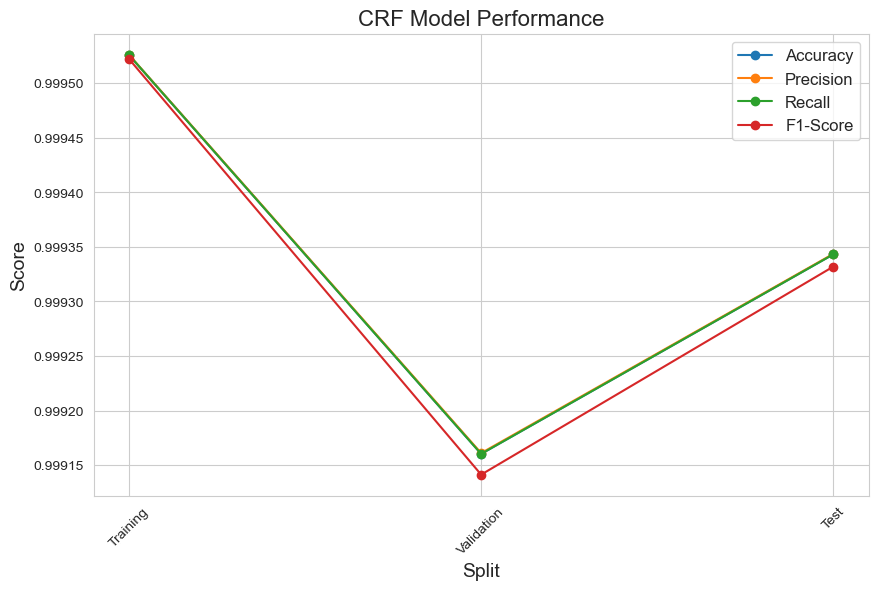

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate CRF model and store metrics
def evaluate_crf(X, y, label):
    y_pred = crf_model.predict(X)

    # Convert y and y_pred to flattened lists for comparison
    y_flat = [label for seq in y for label in seq]
    y_pred_flat = [label for seq in y_pred for label in seq]

    # Calculate accuracy
    accuracy = accuracy_score(y_flat, y_pred_flat)

    # Calculate classification report
    report = classification_report(y_flat, y_pred_flat, output_dict=True)

    # Store metrics
    metrics = {
        'Split': label,
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

    return metrics

# Train the CRF model
train_crf(X_train, y_train)

# Evaluate the model and store metrics
metrics = []
metrics.append(evaluate_crf(X_train, y_train, "Training"))
metrics.append(evaluate_crf(X_val, y_val, "Validation"))
metrics.append(evaluate_crf(X_test, y_test, "Test"))

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot metrics using seaborn
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plt.plot(metrics_df['Split'], metrics_df[metric], marker='o', label=metric)

plt.xlabel('Split', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('CRF Model Performance', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()

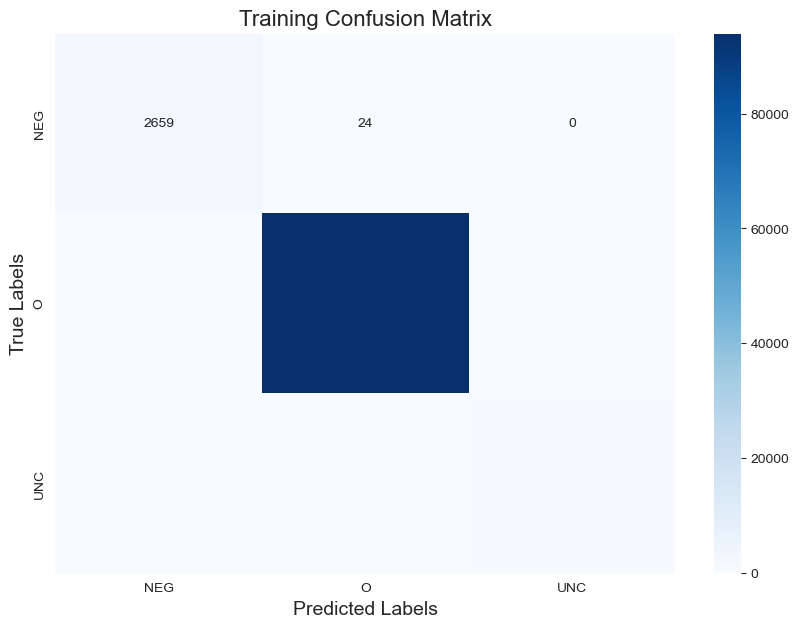

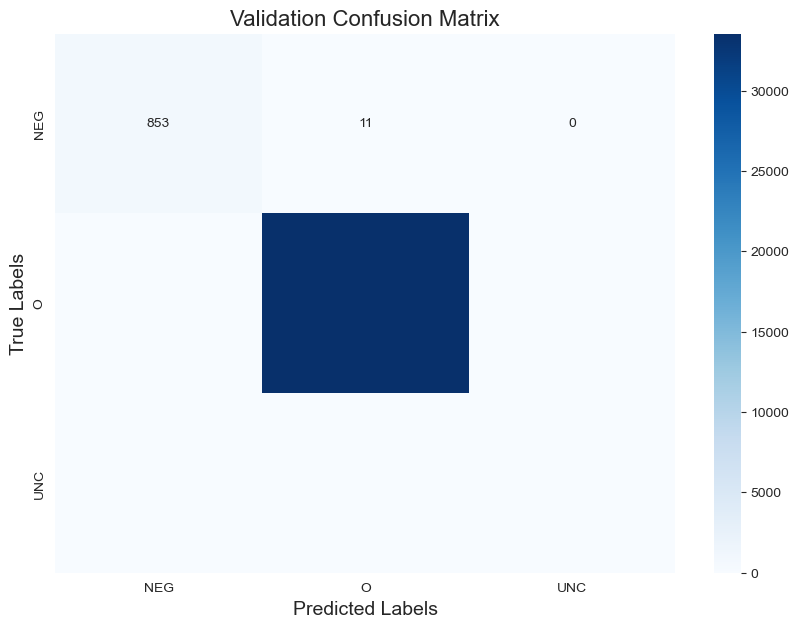

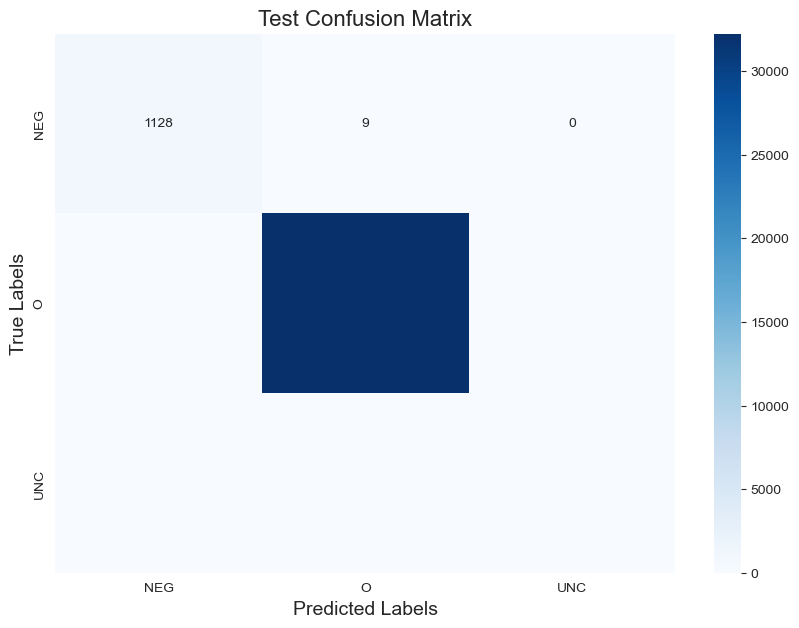

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()

# Get unique labels
unique_labels = list(set([label for seq in y_train for label in seq]))

# Plot confusion matrix for training data
y_train_flat = [label for seq in y_train for label in seq]
y_train_pred_flat = [label for seq in crf_model.predict(X_train) for label in seq]
plot_confusion_matrix(y_train_flat, y_train_pred_flat, unique_labels, 'Training Confusion Matrix')

# Plot confusion matrix for validation data
y_val_flat = [label for seq in y_val for label in seq]
y_val_pred_flat = [label for seq in crf_model.predict(X_val) for label in seq]
plot_confusion_matrix(y_val_flat, y_val_pred_flat, unique_labels, 'Validation Confusion Matrix')

# Plot confusion matrix for test data
y_test_flat = [label for seq in y_test for label in seq]
y_test_pred_flat = [label for seq in crf_model.predict(X_test) for label in seq]
plot_confusion_matrix(y_test_flat, y_test_pred_flat, unique_labels, 'Test Confusion Matrix')